In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 57.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [ ]:
import pandas as pd
import datetime
import time
import requests
import unicodedata
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from google.colab import files
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch


#Load Dataset

In [ ]:
# Load the dataset
df = pd.read_csv("mcdonalds_comments_2024_2025.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5253 entries, 0 to 5252
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Post Title  5253 non-null   object
 1   Comment     5253 non-null   object
 2   Upvotes     5253 non-null   int64 
 3   Timestamp   5253 non-null   object
dtypes: int64(1), object(3)
memory usage: 164.3+ KB


In [ ]:
!pip install gensim
from gensim.parsing.preprocessing import STOPWORDS

In [ ]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")


# Define stopwords set
stop_words = set(stopwords.words('english')).union(set(STOPWORDS))
custom_stopwords = set([
     'mcdonalds', 'mc', 'donalds', 'mcd', 'drive', 'thru', 'fast', 'food', 'order',
    'restaurant', 'meal', 'burgers', 'burger', 'staff', 'location', 'customer',
    'service', 'fries', 'place', 'time', 'got', 'one', 'really', 'wa', 'just',
    'could', 'also', 'im', 'dont', 'didnt', 'theyll', 'youre', 'ive', 'theyre',
    'theyll', 'thats', 'yeah', 'lol', 'u', 'us',
    'got', 'like', 'thing', 'really', 'one', 'even', 'would',
    'the', 'a', 'to', 'i', 'of', 'and', 'in', 'it', 'is', 'that', 'they', 'for',
    'my', 'with', 'too', 'not', 'on', 'at', 'if', 'as', 'from', 'are', 'this',
    'was', 'be', 'its', 'had', 'so', 'an', 'who', 'because', 'we', 'he', 'she',
    'do', 'does', 'did', 'about', 'there', 'been', 'them', 'what', 'when',
    'which', 'how', 'where', 'why', 'their', 'then', 'have', 'has', 'having',
    'me', 'him', 'her', 'our', 'ours', 'yours', 'theirs'
])
lemmatizer = WordNetLemmatizer()

df.dropna(subset=["Comment"], inplace=True)
df = df[df["Comment"].astype(str).str.strip().replace(r'\s+', '', regex=True) != ""]

df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")

df.drop_duplicates(subset=["Comment"], inplace=True)

df = df.reset_index(drop=True)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["Comment"] = df["Comment"].astype(str).apply(clean_text)

df["Tokenized_Comment"] = df["Comment"].apply(
    lambda x: " ".join([
        lemmatizer.lemmatize(word)
        for word in x.split()
        if lemmatizer.lemmatize(word) not in custom_stopwords
    ])
)

df = df[df["Comment"].astype(str).str.strip().replace(r'\s+', '', regex=True) != ""]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5233 entries, 0 to 5232
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Post Title         5233 non-null   object        
 1   Comment            5233 non-null   object        
 2   Upvotes            5233 non-null   int64         
 3   Timestamp          5233 non-null   datetime64[ns]
 4   Tokenized_Comment  5233 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 204.5+ KB


In [ ]:
# Count rows where 'Tokenized_Comment' is missing (NaN) or empty (only spaces)
blank_count = df["Tokenized_Comment"].isna().sum() + (df["Tokenized_Comment"].astype(str).str.strip() == "").sum()

print(f"Number of blank cells in 'Tokenized_Comment': {blank_count}")

Number of blank cells in 'Tokenized_Comment': 31


In [ ]:
df = df[df["Tokenized_Comment"].astype(str).str.strip() != ""]
df = df.dropna(subset=["Tokenized_Comment"])
print(f"Remaining rows: {len(df)}")

Remaining rows: 5202


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5202 entries, 0 to 5232
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Post Title         5202 non-null   object        
 1   Comment            5202 non-null   object        
 2   Upvotes            5202 non-null   int64         
 3   Timestamp          5202 non-null   datetime64[ns]
 4   Tokenized_Comment  5202 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 243.8+ KB


In [ ]:
remaining = []

for word in custom_stopwords:
    if df["Tokenized_Comment"].str.contains(rf"\b{word}\b", regex=True).any():
        remaining.append(word)

print("Stopwords still present:", remaining)

Stopwords still present: []


In [ ]:
# Select only wanted row
df_filtered = df[["Timestamp","Comment","Tokenized_Comment"]]

df_filtered.head()

,Timestamp,Comment,Tokenized_Comment
0,2024-10-22 22:39:00,update e coli outbreak linked to mcdonalds qua...,update e coli outbreak linked quarter pounder ...
1,2024-10-23 02:47:00,i just had it 3 hrs ago in northeast in app i ...,3 hr ago northeast app see now stopped selling...
2,2024-10-22 23:31:00,so many food outbreaks lately,many outbreak lately
3,2024-10-24 05:48:00,my husband was in the er yesterday likely from...,husband er yesterday likely e coli after eatin...
4,2024-10-23 00:29:00,i ate a quarter pounder today while scrolling ...,ate quarter pounder today while scrolling redd...


In [ ]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5202 entries, 0 to 5232
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Timestamp          5202 non-null   datetime64[ns]
 1   Comment            5202 non-null   object        
 2   Tokenized_Comment  5202 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 162.6+ KB


In [ ]:
df_filtered.to_csv("LDA_filtered_data.csv", index=False)

In [ ]:
files.download("LDA_filtered_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#BERTweet Labeled

In [ ]:
!pip install --upgrade numpy
!pip install opencv-python-headless==4.8.0.76

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 101.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 15.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.

In [ ]:
df2 = pd.read_csv("LDA_filtered_data.csv")

model_name = "vinai/bertweet-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
model = AutoModelForSequenceClassification.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")

def get_berttweet_sentiment(text):
    if pd.isna(text) or text.strip() == "":
        return "Neutral"

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    sentiment_class = torch.argmax(logits).item()

    sentiment_labels = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return sentiment_labels[sentiment_class]

df2["BERTweet_Sentiment"] = df2["Comment"].apply(get_berttweet_sentiment)

df2.to_csv("LDA_filtered_data_with_berttweet_sentiment.csv", index=False)

print("Sentiment analysis completed! The results are saved in 'LDA_filtered_data_with_bertweet_sentiment.csv'.")

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Sentiment analysis completed! The results are saved in 'LDA_filtered_data_with_berttweet_sentiment.csv'.


In [ ]:
df2 = pd.read_csv("LDA_filtered_data_with_bertweet_sentiment.csv")
df2.head()

,Timestamp,Comment,Tokenized_Comment,BERTweet_Sentiment
0,2024-10-22 22:39:00,update e coli outbreak linked to mcdonalds qua...,update e coli outbreak linked quarter pounder ...,Negative
1,2024-10-23 02:47:00,i just had it 3 hrs ago in northeast in app i ...,3 hr ago northeast app see now stopped selling...,Negative
2,2024-10-22 23:31:00,so many food outbreaks lately,many outbreak lately,Negative
3,2024-10-24 05:48:00,my husband was in the er yesterday likely from...,husband er yesterday likely e coli after eatin...,Neutral
4,2024-10-23 00:29:00,i ate a quarter pounder today while scrolling ...,ate quarter pounder today while scrolling redd...,Neutral


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5202 entries, 0 to 5201
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Timestamp           5202 non-null   object
 1   Comment             5202 non-null   object
 2   Tokenized_Comment   5202 non-null   object
 3   BERTweet_Sentiment  5202 non-null   object
dtypes: object(4)
memory usage: 162.7+ KB


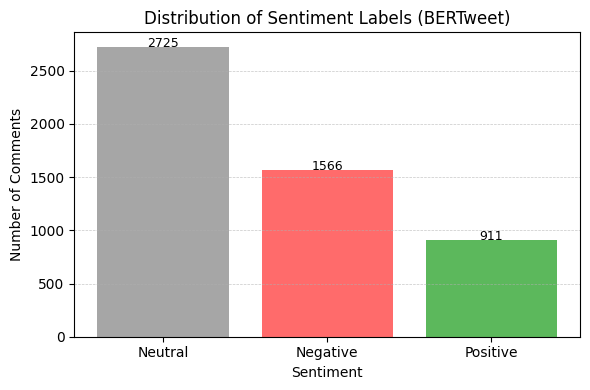

In [ ]:
import matplotlib.pyplot as plt

sentiment_order = ['Neutral', 'Negative', 'Positive']
custom_colors = ['#A6A6A6', '#FF6B6B', '#5CB85C']

sentiment_counts = df2['BERTweet_Sentiment'].value_counts().reindex(sentiment_order, fill_value=0)


plt.figure(figsize=(6, 4))
bars = plt.bar(sentiment_order, sentiment_counts[sentiment_order], color=custom_colors)


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, int(yval), ha='center', fontsize=9)


plt.title('Distribution of Sentiment Labels (BERTweet)', fontsize=12)
plt.xlabel('Sentiment', fontsize=10)
plt.ylabel('Number of Comments', fontsize=10)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()



In [ ]:
negative_df = df2[df2['BERTweet_Sentiment'] == 'Negative']
negative_df.head()

,Timestamp,Comment,Tokenized_Comment,BERTweet_Sentiment
0,2024-10-22 22:39:00,update e coli outbreak linked to mcdonalds qua...,update e coli outbreak linked quarter pounder ...,Negative
1,2024-10-23 02:47:00,i just had it 3 hrs ago in northeast in app i ...,3 hr ago northeast app see now stopped selling...,Negative
2,2024-10-22 23:31:00,so many food outbreaks lately,many outbreak lately,Negative
8,2024-10-23 06:42:00,im from colorado and i heard about this on the...,colorado heard news very sad very scary,Negative
9,2024-10-24 22:35:00,stores in austin texas have all removed from t...,store austin texas all removed menu tx,Negative


In [ ]:
negative_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1566 entries, 0 to 5196
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Timestamp           1566 non-null   object
 1   Comment             1566 non-null   object
 2   Tokenized_Comment   1566 non-null   object
 3   BERTweet_Sentiment  1566 non-null   object
dtypes: object(4)
memory usage: 93.5+ KB


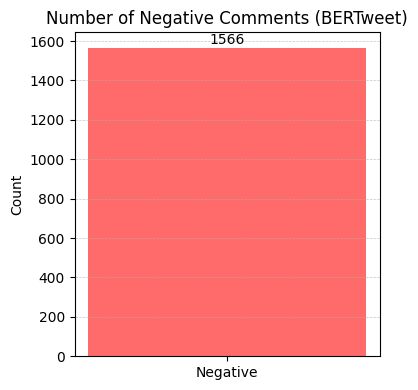

In [ ]:
negative_count = df2['BERTweet_Sentiment'].value_counts().get('Negative', 0)

plt.figure(figsize=(4, 4))
bar = plt.bar(['Negative'], [negative_count], color='#FF6B6B')

plt.text(0, negative_count + 20, str(negative_count), ha='center', fontsize=10)

plt.title('Number of Negative Comments (BERTweet)', fontsize=12)
plt.ylabel('Count', fontsize=10)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Save the filtered data to CSV
negative_df.to_csv("negative_comments.csv", index=False)
files.download("negative_comments.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

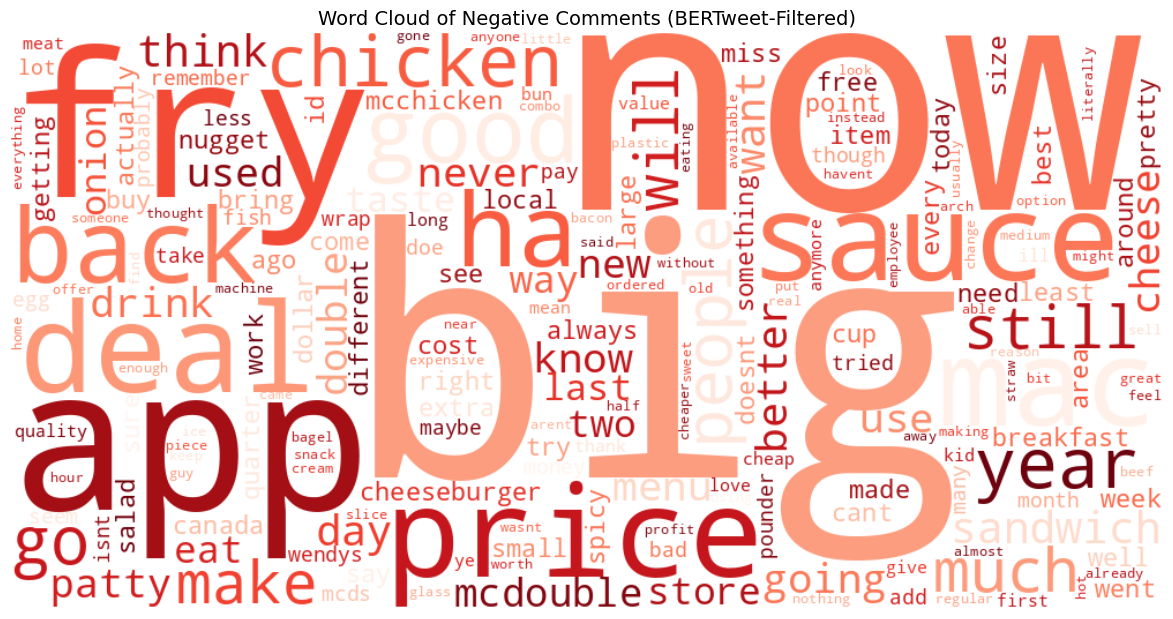

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_data = df2['Tokenized_Comment'].astype(str).str.cat(sep=' ')

wordcloud = WordCloud(width=1000, height=500, background_color='white', colormap='Reds',
                      max_words=200, collocations=False).generate(text_data)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Negative Comments (BERTweet-Filtered)', fontsize=14)
plt.tight_layout(pad=0)
plt.show()